In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy

from pycbc import conversions, psd
from pycbc.filter import match

from simple_pe.param_est import metric
from pesummary.utils.samples_dict import SamplesDict
from pesummary.gw.conversions import convert

In [2]:
plt.rcParams.update({
    "lines.markersize": 6,
    "lines.markeredgewidth": 1.5,
    "lines.linewidth": 3.0,
    "font.size": 20,
    "axes.titlesize": 20,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 20,
})

In [3]:
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

## GW190412-like signal

## Read in PSDs, etc

In [4]:
ifos = ['H1', 'L1', 'V1']

psds = {'H1': 'aLIGOMidHighSensitivityP1200087',
        'L1': 'aLIGOMidHighSensitivityP1200087',
        'V1': 'AdVMidHighSensitivityP1200087',
        'f_low': 20.,
        'f_high': 8192,
        'length': 32
        }

psds['delta_f'] = 1. / psds['length']

approximant = 'IMRPhenomXPHM'

In [5]:
pycbc_psd = {}
for ifo in ifos:
    pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                psds['f_low'])

pycbc_psd['harm'] = 3. / sum([1. / pycbc_psd[ifo] for ifo in ifos])

/home/spxsf2/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in true_divide
  return self._data.__rtruediv__(other)


## Parameters

In [6]:
m1 = 30.
m2 = 10.
mc = conversions.mchirp_from_mass1_mass2(m1, m2)
eta = conversions.eta_from_mass1_mass2(m1, m2)
s1z = 0.3
s2z = 0.
chi_eff = conversions.chi_eff(m1, m2, s1z, s2z)
snr = 18

In [7]:
params = {'mass_1': m1,
          'mass_2': m2,
          'spin_1z': s1z,
          'spin_2z': s2z
        }

## Spin directions

In [8]:
dx_directions = ['spin_1z', 'spin_2z']

In [9]:
params

{'mass_1': 30.0, 'mass_2': 10.0, 'spin_1z': 0.3, 'spin_2z': 0.0}

In [10]:
from simple_pe.param_est import pe

In [11]:
pe.SimplePESamples(params)

{'mass_1': Array(30.),
 'mass_2': Array(10.),
 'spin_1z': Array(0.3),
 'spin_2z': Array(0.)}

In [12]:
for k,i in params.items():
    if type(i) == float:
        params[k] = list([i])

In [13]:
pp = pe.SimplePESamples(params)

In [14]:
pp.add_fixed('phase', 0)

In [15]:
g_spin = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [16]:
print(g_spin.dx_directions)
print(g_spin.metric)
print(g_spin.evec)
print(g_spin.evals)

['spin_1z', 'spin_2z']
[[39.23808957  9.02490263]
 [ 9.02490263  2.07803439]]
[[ 0.97455536 -0.22414692]
 [ 0.22414692  0.97455536]]
[4.13139739e+01 2.16229045e-03]


In [17]:
spin_ellipse = g_spin.generate_ellipse()

In [18]:
spin_post = g_spin.generate_posterior_grid(npts=21, scale=1.3)

In [19]:
chi1, chi2 = np.mgrid[0:0.6:21j, -1:1:21j]
q = m2/m1
chieff = (chi1 + q * chi2)/(1+q)

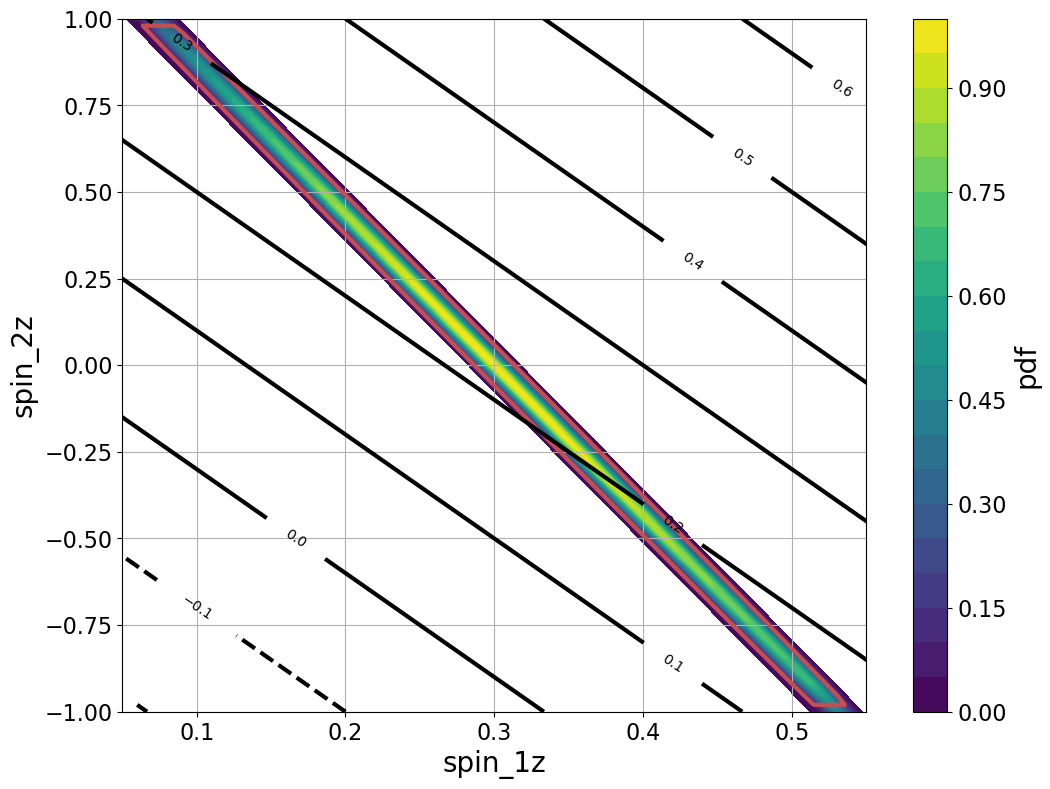

In [20]:
plt.figure(figsize=(12, 9))
plt.contourf(spin_post.samples[0], spin_post.samples[1], spin_post['posterior'], levels=np.linspace(0, 1, 21))
plt.xlabel(spin_post.keys()[0])
plt.ylabel(spin_post.keys()[1])
plt.colorbar(label='pdf')
plt.plot(spin_ellipse.samples[0], spin_ellipse.samples[1], 'r')
chi_cont = plt.contour(chi1, chi2, chieff, colors='k', levels=np.arange(-1,1,0.1))
plt.clabel(chi_cont, fontsize=10)
plt.xlim([0.05, 0.55])
plt.ylim([-1,1])
plt.grid()
plt.savefig('spin_measurement.png')

## Masses

In [21]:
dx_directions = ['mass_1', 'mass_2']

In [22]:
g_mass = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [23]:
mass_ellipse = g_mass.generate_ellipse()

In [24]:
mass_post = g_mass.generate_posterior_grid(npts=21, scale=1.3)

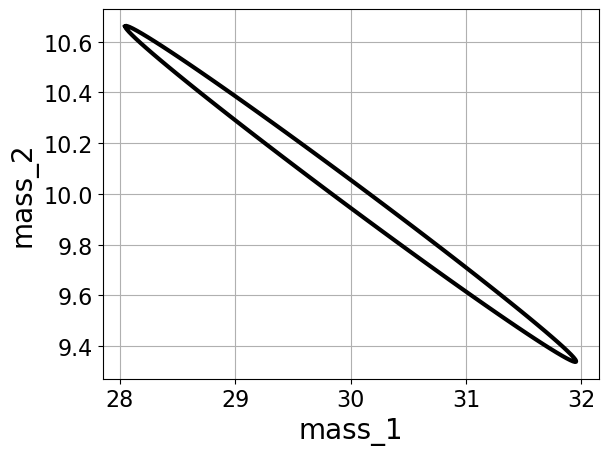

In [25]:
plt.plot(mass_ellipse.samples[0], mass_ellipse.samples[1], 'k')
plt.xlabel(mass_ellipse.keys()[0])
plt.ylabel(mass_ellipse.keys()[1])
plt.grid()

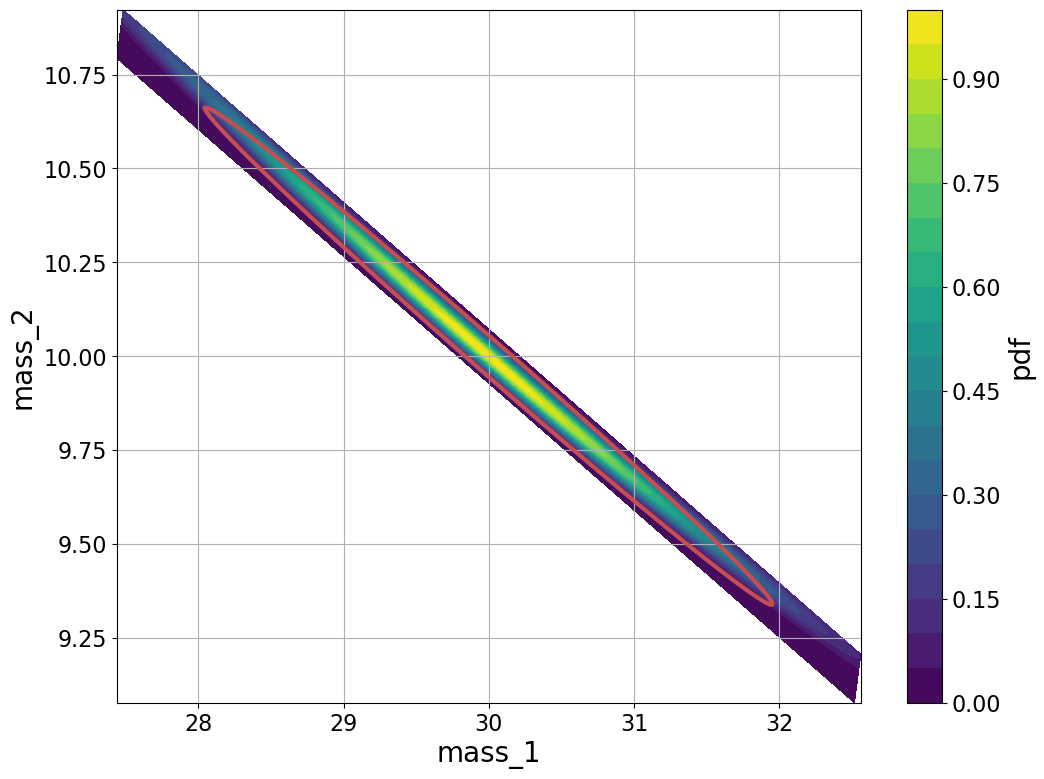

In [26]:
plt.figure(figsize=(12, 9))
plt.contourf(mass_post.samples[0], mass_post.samples[1], mass_post['posterior'], levels=np.linspace(0, 1, 21))
plt.xlabel(mass_post.keys()[0])
plt.ylabel(mass_post.keys()[1])
plt.colorbar(label='pdf')
plt.plot(mass_ellipse.samples[0], mass_ellipse.samples[1], 'r')
plt.grid()

### Repeat with chirp mass and eta

In [27]:
params = {'chirp_mass': mc,
          'symmetric_mass_ratio': eta,
          'spin_1z': s1z,
          'spin_2z': s2z
        }

In [28]:
dx_directions = ['chirp_mass', 'symmetric_mass_ratio']

In [29]:
g_mceta = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [30]:
mceta_ellipse = g_mceta.generate_ellipse()

In [31]:
mceta_post = g_mceta.generate_posterior_grid(npts=21, scale=1.3)
mceta_match = g_mceta.generate_match_grid(npts=21, scale=1.3)

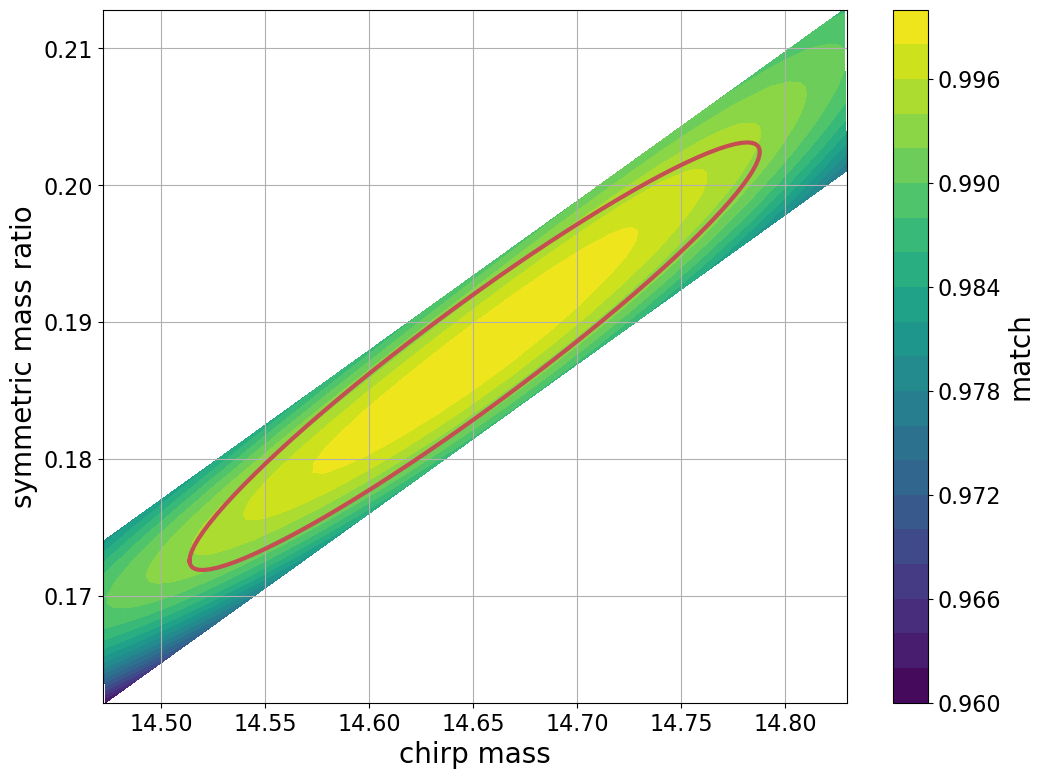

In [32]:
plt.figure(figsize=(12, 9))
plt.contourf(mceta_match.samples[0], mceta_match.samples[1], mceta_match['match'], levels=np.linspace(0.96, 1, 21))
plt.xlabel(mceta_match.keys()[0].replace('_',' '))
plt.ylabel(mceta_match.keys()[1].replace('_',' '))
plt.colorbar(label='match')
plt.plot(mceta_ellipse.samples[0], mceta_ellipse.samples[1], 'r')
plt.grid()

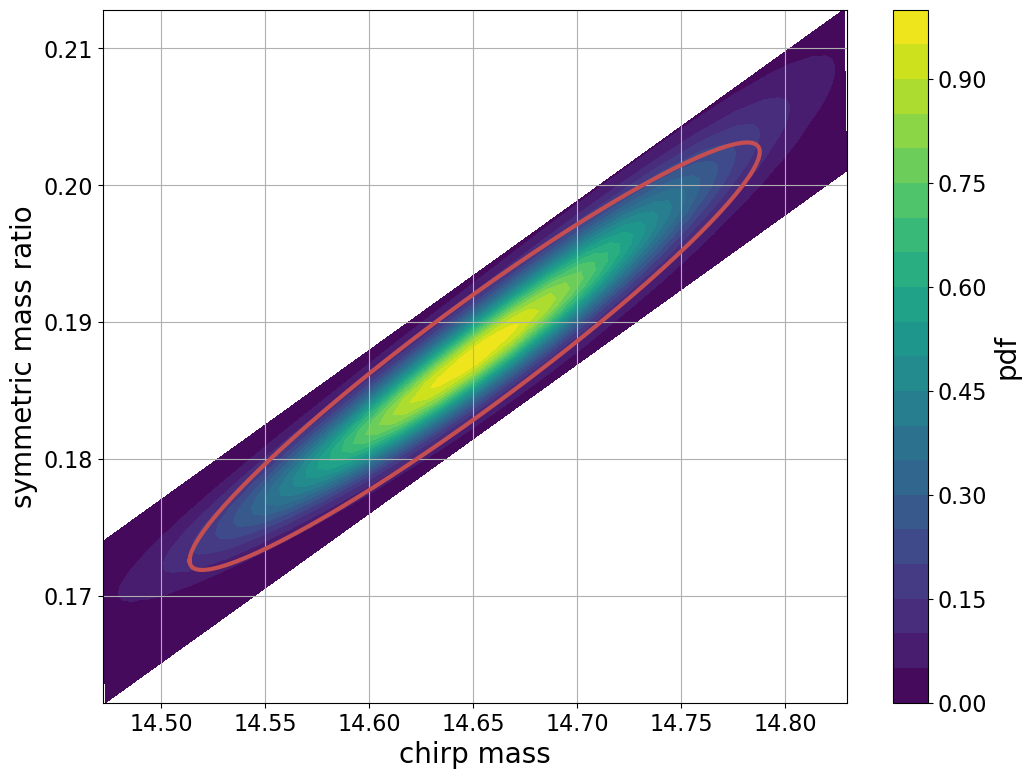

In [33]:
plt.figure(figsize=(12, 9))
plt.contourf(mceta_post.samples[0], mceta_post.samples[1], mceta_post['posterior'], levels=np.linspace(0, 1, 21))
plt.xlabel(mceta_post.keys()[0].replace('_',' '))
plt.ylabel(mceta_post.keys()[1].replace('_',' '))
plt.colorbar(label='pdf')
plt.plot(mceta_ellipse.samples[0], mceta_ellipse.samples[1], 'r')
plt.grid()

In [34]:
mass1 = conversions.mass1_from_mchirp_eta(mceta_post['chirp_mass'], mceta_post['symmetric_mass_ratio'])
mass2 = conversions.mass2_from_mchirp_eta(mceta_post['chirp_mass'], mceta_post['symmetric_mass_ratio'])

mass1_el = conversions.mass1_from_mchirp_eta(mceta_ellipse['chirp_mass'], mceta_ellipse['symmetric_mass_ratio'])
mass2_el = conversions.mass2_from_mchirp_eta(mceta_ellipse['chirp_mass'], mceta_ellipse['symmetric_mass_ratio'])

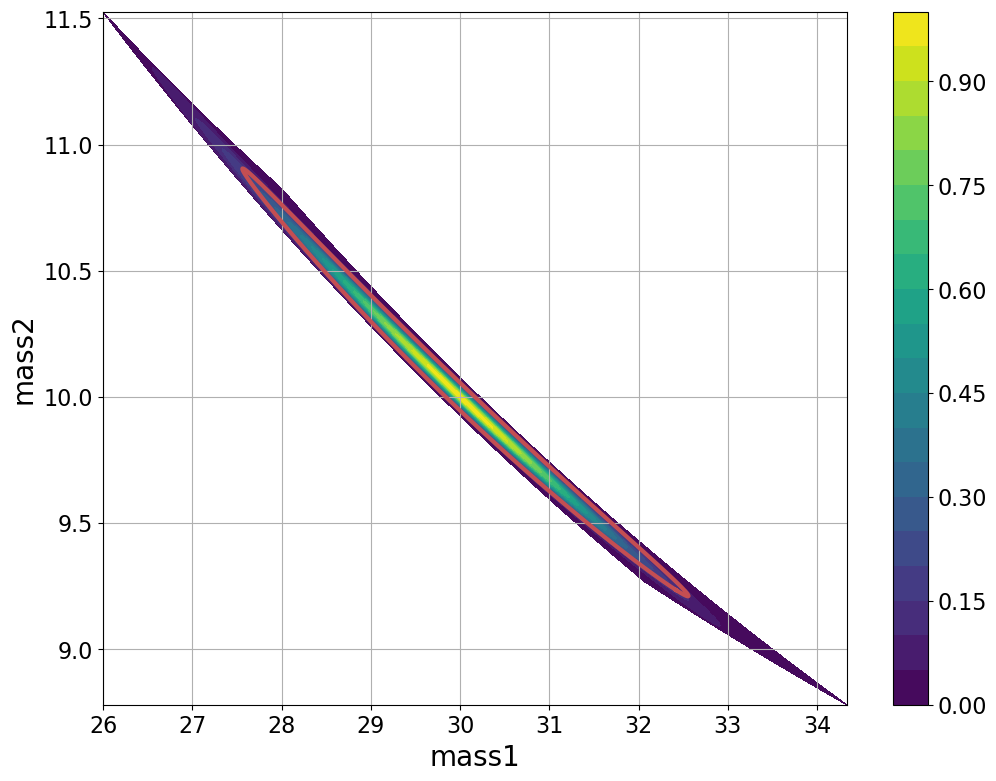

In [35]:
plt.figure(figsize=(12, 9))
plt.contourf(mass1, mass2, mceta_post['posterior'], levels=np.linspace(0, 1, 21))
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.plot(mass1_el, mass2_el, 'r')
plt.colorbar()
plt.grid()

## Three dimensions with projection

Note: we are using "chi_eff", but that's just putting the same spin on both BHs, so probably don't need to worry about the fact that it's not the best measured spin direction.

In [36]:
params = {'chirp_mass': mc,
          'symmetric_mass_ratio': eta,
          'chi_eff':chi_eff
        }

In [37]:
dx_directions = ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']

In [38]:
g_3d = metric.find_metric_and_eigendirections(params, dx_directions, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

### Chirp mass -- eta

In [39]:
dx_keep = ['chirp_mass','symmetric_mass_ratio']


2d calculation

In [40]:
g_mceta = metric.find_metric_and_eigendirections(params, dx_keep, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

In [41]:
mceta_ellipse = mceta_ellipse = g_mceta.generate_ellipse()

mceta_post = g_mceta.generate_posterior_grid(npts=21, scale=1.3)

3d calculation

In [42]:
g_3d.project_metric(dx_keep)
mceta_3d_ellipse = g_3d.generate_ellipse(projected=True)

mceta_proj_post = g_3d.generate_posterior_grid(projected=True, scale=1.3) 

Compare regions

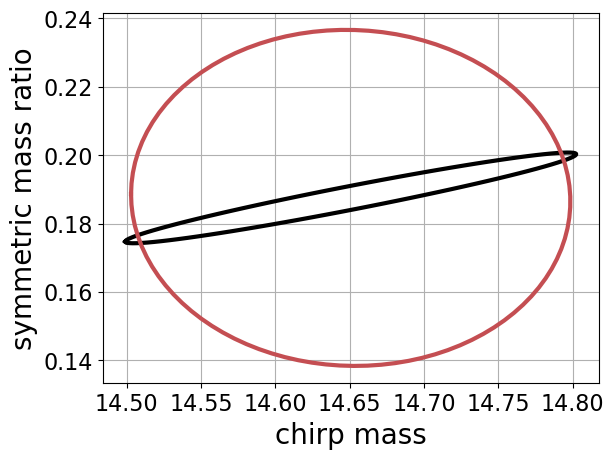

In [43]:
plt.plot(mceta_ellipse.samples[0], mceta_ellipse.samples[1], 'k')
plt.plot(mceta_3d_ellipse.samples[0], mceta_3d_ellipse.samples[1], 'r')
plt.xlabel(mceta_3d_ellipse.keys()[0].replace('_',' '))
plt.ylabel(mceta_3d_ellipse.keys()[1].replace('_',' '))
plt.grid()

Check probabilities

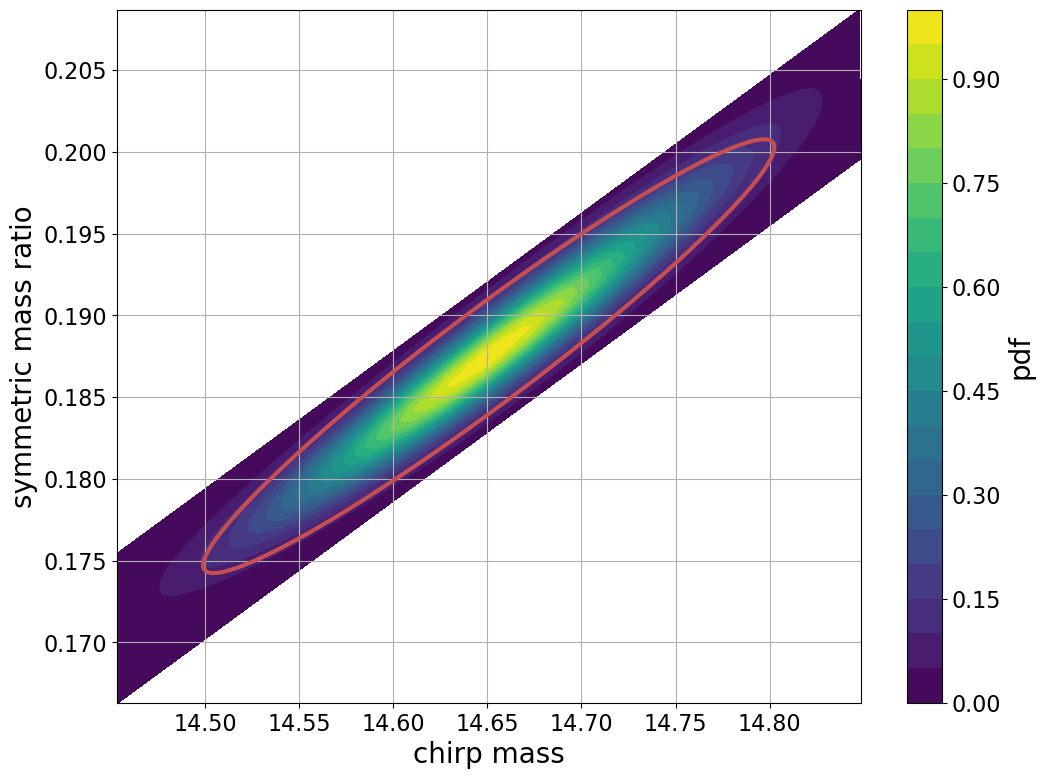

In [44]:
plt.figure(figsize=(12, 9))
plt.contourf(mceta_post.samples[0], mceta_post.samples[1], mceta_post['posterior'], levels=np.linspace(0, 1, 21))
plt.xlabel(mceta_post.keys()[0].replace('_',' '))
plt.ylabel(mceta_post.keys()[1].replace('_',' '))
plt.colorbar(label='pdf')
plt.plot(mceta_ellipse.samples[0], mceta_ellipse.samples[1], 'r')
plt.grid()
plt.savefig('mc_eta_2d_contours.png')

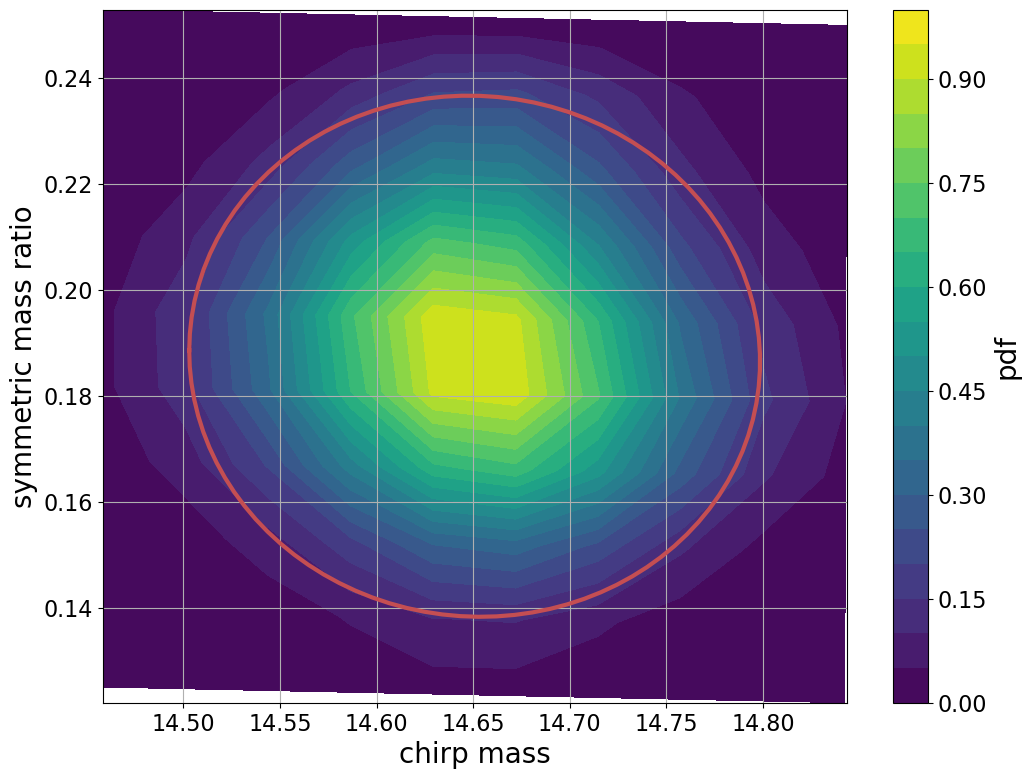

In [45]:
plt.figure(figsize=(12, 9))
plt.contourf(mceta_proj_post.samples[0], 
             mceta_proj_post.samples[1], 
             mceta_proj_post['posterior'], 
             levels=np.linspace(0, 1, 21))
plt.xlabel(mceta_proj_post.keys()[0].replace('_',' '))
plt.ylabel(mceta_proj_post.keys()[1].replace('_',' '))
plt.colorbar(label='pdf')
plt.plot(mceta_3d_ellipse.samples[0], mceta_3d_ellipse.samples[1], 'r', linewidth=3)
plt.grid()
plt.savefig('mc_eta_3d_contours.png')

### eta -- chi eff

In [46]:
dx_keep = ['symmetric_mass_ratio', 'chi_eff']

In [47]:
g_eta_chi = metric.find_metric_and_eigendirections(params, dx_keep, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

eta_chi_ellipse = g_eta_chi.generate_ellipse()

eta_chi_post = g_eta_chi.generate_posterior_grid(scale=1.3, npts=21)

In [48]:
g_3d.project_metric(dx_keep)
eta_chi_3d_ellipse = g_3d.generate_ellipse(projected=True)

eta_chi_proj_post = g_3d.generate_posterior_grid(projected=True, scale=1.3, npts=21)

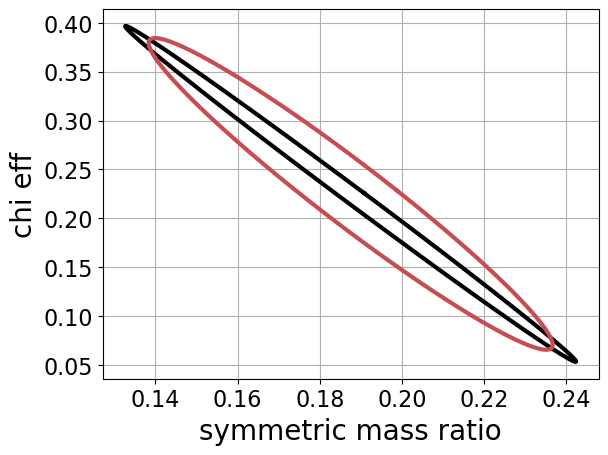

In [49]:
plt.plot(eta_chi_ellipse.samples[0], eta_chi_ellipse.samples[1], 'k')
plt.plot(eta_chi_3d_ellipse.samples[0], eta_chi_3d_ellipse.samples[1], 'r')
plt.xlabel(eta_chi_3d_ellipse.keys()[0].replace('_',' '))
plt.ylabel(eta_chi_3d_ellipse.keys()[1].replace('_',' '))
plt.grid()
plt.savefig('eta_chi_contours.png')

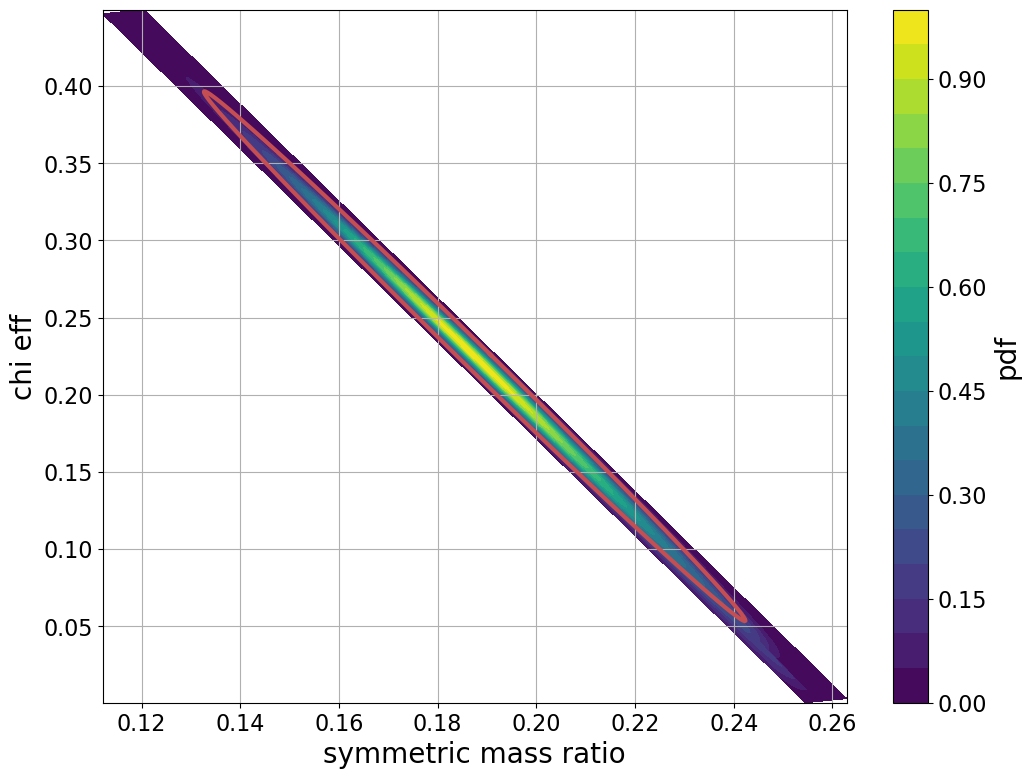

In [50]:
plt.figure(figsize=(12, 9))
plt.contourf(eta_chi_post.samples[0], eta_chi_post.samples[1], eta_chi_post['posterior'], levels=np.linspace(0, 1, 21))
plt.xlabel(eta_chi_post.keys()[0].replace('_',' '))
plt.ylabel(eta_chi_post.keys()[1].replace('_',' '))
plt.colorbar(label='pdf')
plt.plot(eta_chi_ellipse.samples[0], eta_chi_ellipse.samples[1], 'r')
plt.grid()

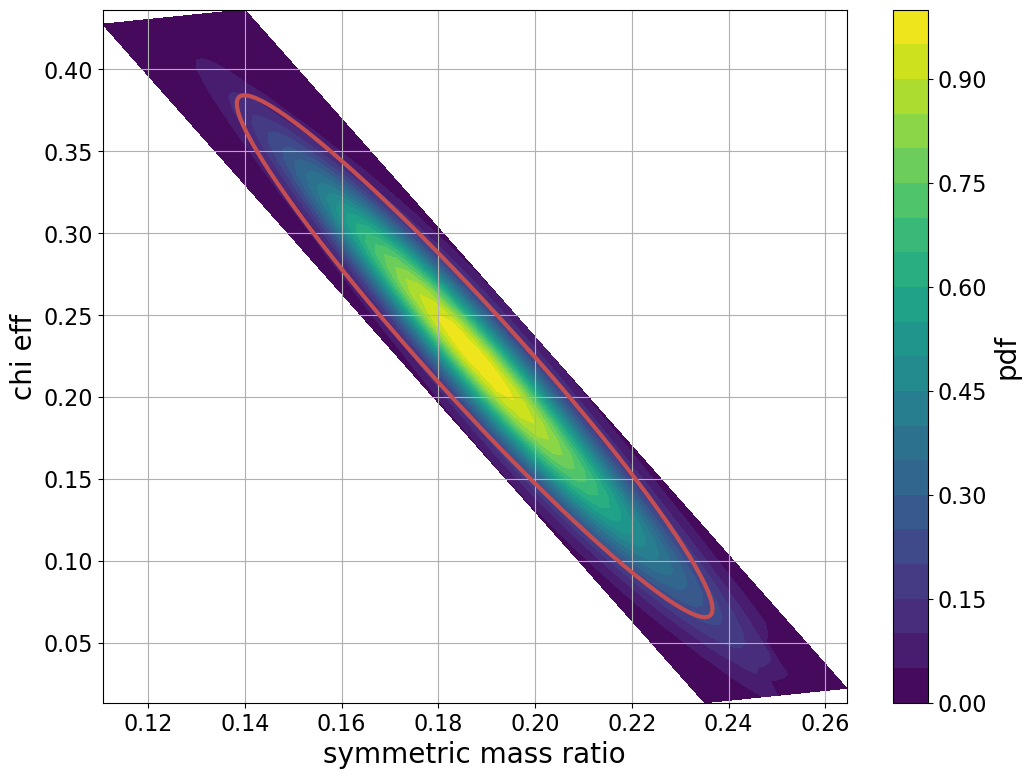

In [51]:
plt.figure(figsize=(12, 9))
plt.contourf(eta_chi_proj_post.samples[0], 
             eta_chi_proj_post.samples[1], 
             eta_chi_proj_post['posterior'], 
             levels=np.linspace(0, 1, 21))
plt.xlabel(eta_chi_proj_post.keys()[0].replace('_',' '))
plt.ylabel(eta_chi_proj_post.keys()[1].replace('_',' '))
plt.colorbar(label='pdf')
plt.plot(eta_chi_3d_ellipse.samples[0], eta_chi_3d_ellipse.samples[1], 'r', linewidth=3)
plt.grid()
plt.savefig('eta_chi_3d_contours.png')

### chirp mass -- chi eff

In [52]:
dx_keep = ['chirp_mass', 'chi_eff']

In [53]:
g_mc_chi = metric.find_metric_and_eigendirections(params, dx_keep, snr, psds['f_low'], pycbc_psd['harm'], 
                                     approximant, tolerance=0.01, max_iter=20)

mc_chi_ellipse = g_mc_chi.generate_ellipse()

mc_chi_post = g_mc_chi.generate_posterior_grid(scale=1.3, npts=21)

In [54]:
g_3d.project_metric(dx_keep)
mc_chi_3d_ellipse = g_3d.generate_ellipse(projected=True)

In [55]:
mc_chi_proj_post = g_3d.generate_posterior_grid(projected=True, npts=21, scale=1.2)

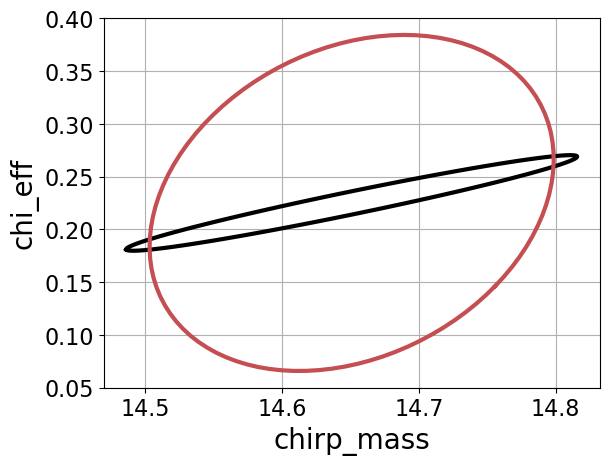

In [56]:
plt.plot(mc_chi_ellipse.samples[0], mc_chi_ellipse.samples[1], 'k')
plt.plot(mc_chi_3d_ellipse.samples[0], mc_chi_3d_ellipse.samples[1], 'r')
plt.xlabel(mc_chi_3d_ellipse.keys()[0])
plt.ylabel(mc_chi_3d_ellipse.keys()[1])
plt.grid()

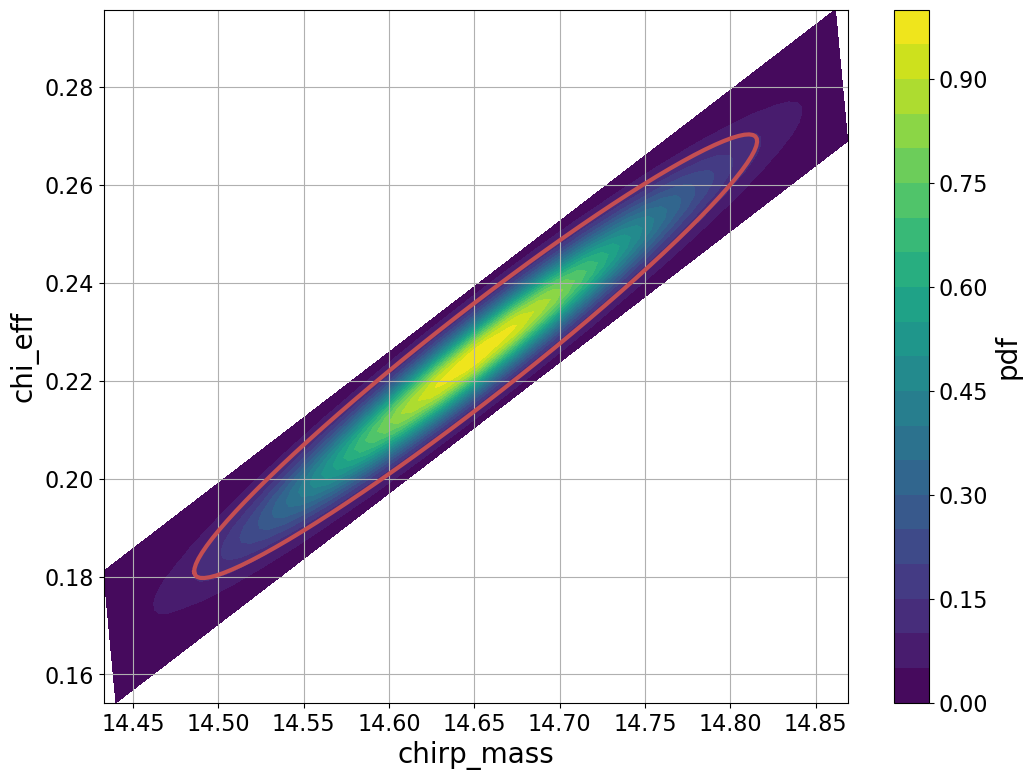

In [57]:
plt.figure(figsize=(12, 9))
plt.contourf(mc_chi_post.samples[0], mc_chi_post.samples[1], mc_chi_post['posterior'], levels=np.linspace(0, 1, 21))
plt.xlabel(mc_chi_post.keys()[0])
plt.ylabel(mc_chi_post.keys()[1])
plt.colorbar(label='pdf')
plt.plot(mc_chi_ellipse.samples[0], mc_chi_ellipse.samples[1], 'r', linewidth=3)
plt.grid()

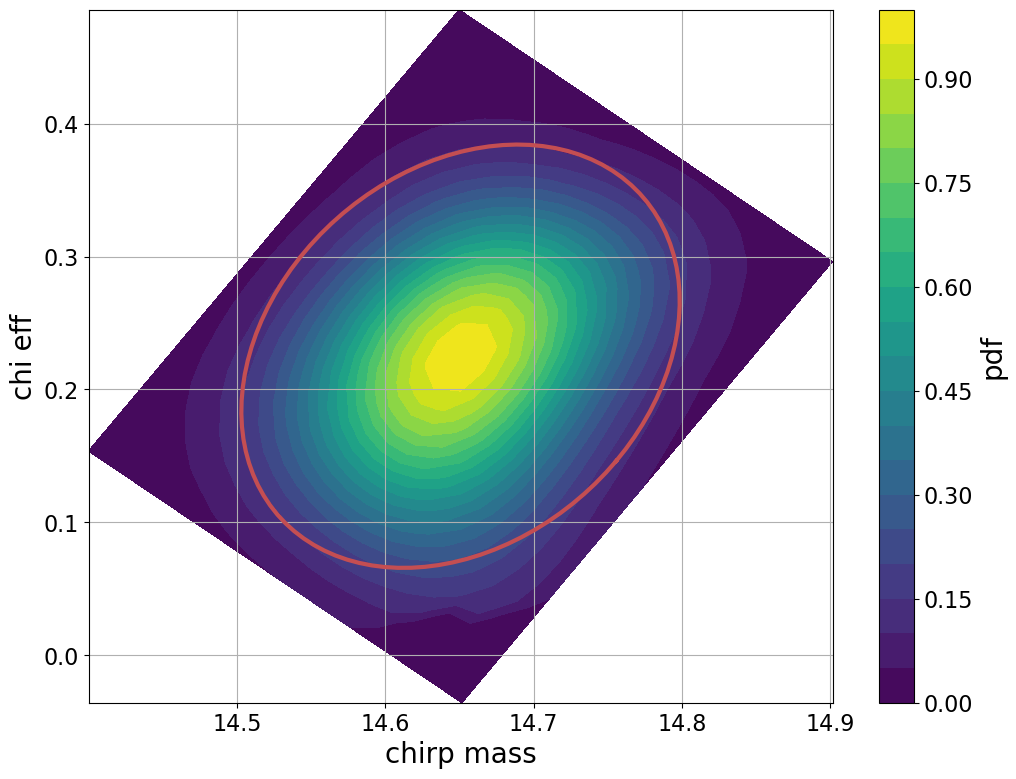

In [58]:
plt.figure(figsize=(12, 9))
plt.contourf(mc_chi_proj_post.samples[0], 
             mc_chi_proj_post.samples[1], 
             mc_chi_proj_post['posterior'], 
             levels=np.linspace(0, 1, 21))
plt.xlabel(mc_chi_proj_post.keys()[0].replace('_',' '))
plt.ylabel(mc_chi_proj_post.keys()[1].replace('_',' '))
plt.colorbar(label='pdf')
plt.plot(mc_chi_3d_ellipse.samples[0], mc_chi_3d_ellipse.samples[1], 'r', linewidth=3)
plt.grid()
plt.savefig('mc_chi_3d_contours.png')